# Анализ поведения пользователей мобильного приложения #

Получив файл с данными /datasets/logs_exp.csv, который хранит сведения о пользователях, их поведении, времени совершения события и номер его экспериментальной группы. На основе этих данных мы построим нашу дальнейшую работу, проанализировав их. 

**Задача, которую мы пытаемся решить в данном исследовании, следующая:** дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

**На основе этих данных мы проведем исследование и построим нашу работу следующим образом:**

1. Загрузим данные и подготовим их для анализа;
2. Изучим и проверим данные;
3. Изучим воронку продаж;
4. Исследуем результаты A/A/B-эксперимента;
5. Сделаем необходимые нам выводы.

**Шаг 1: загрузка и предварительное изучение данных файла**

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
log_s = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
log_s.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
log_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датасете хранится информация с 4 столбцов: EventName, DeviceIDHash, EventTimestamp и EventTimestamp. Начнем с того, что приведем наименования столбцов к стандартному виду.
Далее перейдём к приведению столбца EventTimestamp к типу datetime.

Пропусков в данных не обнаружено.

In [4]:
log_s.rename(columns = {'DeviceIDHash':'user_id', 'EventTimestamp':'date', 'ExpId': 'ex_id', 'EventName': 'event'},
            inplace = True )

In [5]:
log_s['date'] = pd.to_datetime(log_s['date'], unit='s')
log_s

,event,user_id,date,ex_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [6]:
log_s['date_wt'] = pd.to_datetime(log_s['date']).dt.date
log_s

,event,user_id,date,ex_id,date_wt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Проверим данные на наличие дубликатов.

In [7]:
log_s.duplicated().sum()

413

Избавимся от строчек, содержащих дубликаты.

In [8]:
log_s = log_s.drop_duplicates()

**Шаг 2: изучим и проверим данные**

In [9]:
log_s.nunique()

event           5
user_id      7551
date       176654
ex_id           3
date_wt        14
dtype: int64

В логе 5 событий и 7551 пользователей. 

In [10]:
avg = log_s.groupby('user_id').agg({'event': 'count'})
avg.describe()

,event
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


В среднем на одного пользователя приходится 32 события.

In [11]:
print(log_s['date_wt'].max())
print(log_s['date_wt'].min())

2019-08-07
2019-07-25


В датасете хранятся данные с 25 июля по 7 августа. Определим количество событий в зависимости от времени в разрезе групп.

In [12]:
data = pd.pivot_table(log_s, index='date_wt', columns='ex_id', values='event', aggfunc='count')
data

ex_id,246,247,248
date_wt,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


<AxesSubplot:title={'center':'Количество событий в зависимости от времени в разрезе групп'}, xlabel='Дата', ylabel='Количество событий'>

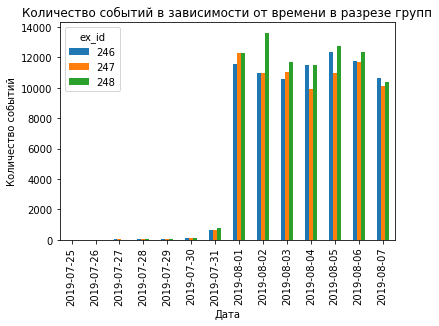

In [13]:
data.plot(kind='bar', title='Количество событий в зависимости от времени в разрезе групп', 
          xlabel='Дата', ylabel='Количество событий')

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». В промежутке с 25 по 31 июля событий было недостаточно много для корректного анализа данных. Поэтому отберем для анализа данные за неделю: в промежутке с 1 по 7 августа.

In [14]:
log_s['date_wt'] = pd.to_datetime(log_s['date_wt'])
logs = log_s[log_s['date_wt'] > '2019-07-31']
logs.head(20)

/tmp/ipykernel_48/4147226595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_s['date_wt'] = pd.to_datetime(log_s['date_wt'])


,event,user_id,date,ex_id,date_wt
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01
2835,MainScreenAppear,3737462046622621720,2019-08-01 00:10:47,246,2019-08-01
2836,MainScreenAppear,3737462046622621720,2019-08-01 00:11:10,246,2019-08-01
2837,MainScreenAppear,3737462046622621720,2019-08-01 00:11:20,246,2019-08-01


In [15]:
print(len(log_s) - len(logs))
print(log_s['user_id'].nunique() - logs['user_id'].nunique())

2826
17


In [16]:
print(round(((len(log_s) - len(logs)) / len(log_s) * 100), 2))
print(round((((log_s['user_id'].nunique() - logs['user_id'].nunique()) / log_s['user_id'].nunique()) * 100), 2))

1.16
0.23


Оставив данные лишь за вторую неделю мы потеряли записи 2826 событий (чуть больше 1% записей) и 17 пользователей (0.23%), что доступимо для последующих предположений. Пользователи из всех трёх групп остались на месте.

**Шаг 3: изучим воронку событий**

Посмотрим, какие события есть в логах, как часто они встречаются. 
Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [17]:
logs.groupby('event').agg({'date': 'count'}).sort_values(by='date', ascending=False)

,date
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [18]:
data2 = pd.pivot_table(logs, index='event', values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending=False)
data2['part'] = round((data2['user_id'] / logs['user_id'].nunique()) * 100, 2)
data2

,user_id,part
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Судя по анализу, мы можем предположить, что события происходят в следующем порядке: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Событие Tutorial не зависит от других факторов и может проходить в любом порядке. Однако, лишь малое количество пользователей пользуется данным событием, поэтому исключим его из дальнейшего анализа.

Посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [19]:
data2['step'] = ' '
data2['step'][0] = round(data2['user_id'][0] / data2['user_id'][0] * 100, 2)
data2['step'][1] = round(data2['user_id'][1] / data2['user_id'][0] * 100, 2)
data2['step'][2] = round(data2['user_id'][2] / data2['user_id'][1] * 100, 2)
data2['step'][3] = round(data2['user_id'][3] / data2['user_id'][2] * 100, 2)
data2

/tmp/ipykernel_48/2002077017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['step'][0] = round(data2['user_id'][0] / data2['user_id'][0] * 100, 2)
/tmp/ipykernel_48/2002077017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['step'][1] = round(data2['user_id'][1] / data2['user_id'][0] * 100, 2)
/tmp/ipykernel_48/2002077017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['step'][2] = round(data2['user_id'][

,user_id,part,step
event,,,
MainScreenAppear,7419,98.47,100.0
OffersScreenAppear,4593,60.96,61.91
CartScreenAppear,3734,49.56,81.3
PaymentScreenSuccessful,3539,46.97,94.78
Tutorial,840,11.15,


Больше всего пользователей (почти 40%) теряется при переходе от первого ко второму шагу (от MainScreenAppear к OffersScreenAppear).

In [20]:
round(data2['user_id'][3] / data2['user_id'][0] * 100, 2)

47.7

От самого первого события к оплате товара проходит менее половины пользователей – около 48%.

**Шаг 4: изучим результаты эксперимента**

Посчитаем, сколько пользователей в каждой из групп.

In [21]:
logs.groupby('ex_id').agg({'user_id': 'nunique'})

,user_id
ex_id,
246,2484
247,2513
248,2537


In [22]:
logs.groupby('user_id').agg({'ex_id':'nunique'}).query('ex_id > 1') 

,ex_id
user_id,


Все пользователи находятся лишь в одной группе, их повторение в разных группах не обнаружено. Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших каждое событие.

In [23]:
def user_counter(event):
    p1 = logs[logs['event'] == event]
    p2 = p1.groupby('ex_id').agg({'user_id': 'nunique'})
    p3 = logs.groupby('ex_id').agg({'user_id': 'nunique'})
    p2.columns = ['users_event']
    p3.columns = ['users_group']
    p2 = p2.join(p3)
    p2.loc['united', 'users_event'] = p2.loc[246, 'users_event'] + p2.loc[247, 'users_event']
    p2.loc['united', 'users_group'] = p2.loc[246, 'users_group'] + p2.loc[247, 'users_group']
    p2['user_share'] = (p2['users_event'] / p2['users_group']).map(lambda x: '{0:.2%}'.format(x))
    
    return p2

In [24]:
MainScreenAppear = user_counter('MainScreenAppear')
MainScreenAppear

,users_event,users_group,user_share
ex_id,,,
246,2450.0,2484.0,98.63%
247,2476.0,2513.0,98.53%
248,2493.0,2537.0,98.27%
united,4926.0,4997.0,98.58%


In [25]:
OffersScreenAppear = user_counter('OffersScreenAppear')
OffersScreenAppear

,users_event,users_group,user_share
ex_id,,,
246,1542.0,2484.0,62.08%
247,1520.0,2513.0,60.49%
248,1531.0,2537.0,60.35%
united,3062.0,4997.0,61.28%


In [26]:
CartScreenAppear = user_counter('CartScreenAppear')
CartScreenAppear

,users_event,users_group,user_share
ex_id,,,
246,1266.0,2484.0,50.97%
247,1238.0,2513.0,49.26%
248,1230.0,2537.0,48.48%
united,2504.0,4997.0,50.11%


In [27]:
PaymentScreenSuccessful = user_counter('PaymentScreenSuccessful')
PaymentScreenSuccessful

,users_event,users_group,user_share
ex_id,,,
246,1200.0,2484.0,48.31%
247,1158.0,2513.0,46.08%
248,1181.0,2537.0,46.55%
united,2358.0,4997.0,47.19%


Проверим, будет ли отличие между всеми группами статистически достоверным. Начнём с уровня статистической значимости в 99%, после чего проверим по уровню статистической значимости в 95% и 90%.

Зададим гипотезы следующим образом:

Н0 – между долями есть значимая разница

Н1 – нет оснований считать доли разными

In [28]:
alpha = .01 # критический уровень статистической значимости

def zcount(successes, trials):
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Начнём с проверки по событию MainScreenAppear.

In [29]:
zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][247]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][247]]))
zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event'][247], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][247], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event']['united'], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group']['united'], MainScreenAppear['users_group'][248]]))

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь проверим гипотезы для события OffersScreenAppear.

In [30]:
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][247]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][247]]))
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event'][247], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][247], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event']['united'], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group']['united'], OffersScreenAppear['users_group'][248]]))

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь проверим гипотезы для события CartScreenAppear.

In [31]:
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][247]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][247]]))
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event'][247], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][247], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event']['united'], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group']['united'], CartScreenAppear['users_group'][248]]))

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь проверим гипотезы для события PaymentScreenSuccessful.

In [32]:
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][247]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][247]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][247], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][247], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event']['united'], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group']['united'], PaymentScreenSuccessful['users_group'][248]]))

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При критическом уровене статистической значимости в 99% по итогам проведенных тестов мы можем сказать о том, во всех случаях не получилось отвергнуть нулевую гипотезу.

Теперь проверим гипотезы для критического уровня статистической значимости в 95%.

In [33]:
alpha = .05 # критический уровень статистической значимости

def zcount(successes, trials):
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][247]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][247]]))
zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event'][247], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][247], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event']['united'], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group']['united'], MainScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][247]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][247]]))
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event'][247], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][247], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event']['united'], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group']['united'], OffersScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][247]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][247]]))
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event'][247], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][247], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event']['united'], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group']['united'], CartScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][247]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][247]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][247], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][247], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event']['united'], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group']['united'], PaymentScreenSuccessful['users_group'][248]]))

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При критическом уровене статистической значимости в 95% по итогам проведенных тестов мы так же можем сказать о том, во всех случаях не получилось отвергнуть нулевую гипотезу. Теперь проверим гипотезы для критического уровня статистической значимости в 90%.

In [34]:
alpha = .1 # критический уровень статистической значимости

def zcount(successes, trials):
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][247]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][247]]))
zcount(np.array([MainScreenAppear['users_event'][246], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][246], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event'][247], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group'][247], MainScreenAppear['users_group'][248]]))
zcount(np.array([MainScreenAppear['users_event']['united'], MainScreenAppear['users_event'][248]]), 
       np.array([MainScreenAppear['users_group']['united'], MainScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][247]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][247]]))
zcount(np.array([OffersScreenAppear['users_event'][246], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][246], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event'][247], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group'][247], OffersScreenAppear['users_group'][248]]))
zcount(np.array([OffersScreenAppear['users_event']['united'], OffersScreenAppear['users_event'][248]]), 
       np.array([OffersScreenAppear['users_group']['united'], OffersScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][247]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][247]]))
zcount(np.array([CartScreenAppear['users_event'][246], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][246], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event'][247], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group'][247], CartScreenAppear['users_group'][248]]))
zcount(np.array([CartScreenAppear['users_event']['united'], CartScreenAppear['users_event'][248]]), 
       np.array([CartScreenAppear['users_group']['united'], CartScreenAppear['users_group'][248]]))
print('  ')
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][247]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][247]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][246], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][246], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event'][247], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group'][247], PaymentScreenSuccessful['users_group'][248]]))
zcount(np.array([PaymentScreenSuccessful['users_event']['united'], PaymentScreenSuccessful['users_event'][248]]), 
       np.array([PaymentScreenSuccessful['users_group']['united'], PaymentScreenSuccessful['users_group'][248]]))

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При критическом уровне статистической значимости в 90% по итогам проведенных тестов мы можем сказать о том, что значимая разница есть для комбинации между группами 246 и 248 для события CartScreenAppear. Во всех остальных случаев не получилось отвергнуть нулевую гипотезу.

**Шаг 5: общие выводы**

**Проанализировав данные с 1 по 7 августа 2019 года, можно сделать следующие выводы:**
1. В логе 5 событий, 7551 пользователей, 3 контрольный группы и 14 дней. Очистив данные, получили датасет с 5 событиями, 7534 пользователями и 7 днями.
2. В среднем на одного пользователя приходится 32 события.
3. Судя по анализу, мы можем предположить, что события происходят в следующем порядке: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Событие Tutorial не зависит от других факторов и может проходить в любом порядке. Однако, лишь малое количество пользователей пользуется данным событием, поэтому мы исключили его из дальнейшего анализа.
4. Больше всего пользователей (почти 40%) теряется при переходе от первого ко второму шагу (от MainScreenAppear к OffersScreenAppear).
5. От самого первого события к оплате товара проходит менее половины пользователей – около 48%.
6. Практически во всех проведенных нами тестах не получилось отвергнуть нулевую гипотезу о разности долей (кроме события CartScreenAppear для групп 246 и 248 при критическом уровне статистической значимости в 90%). 

На основе результатов A/A/B-эксперимента мы можем сделать предположение о том, что оставив уровень статистической значимости в 95% (самый приемлемый уровень), изменения шрифта не повлияло на поведение пользователей: опасения маркетологов не оправдались – шрифт можно менять!